In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/satellite-image-classification/data/cloudy/train_17406.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_28684.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_33597.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_34079.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_30586.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_18281.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_33296.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_34303.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_1336.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_30792.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_19000.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_13047.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_21750.jpg
/kaggle/input/satellite-image-classification/data/cl

# finetuning and testing by dividing the dataset into train-test.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = ImageFolder(root="/kaggle/input/satellite-image-classification/data", transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Define the dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)


In [3]:
dataset.classes

['cloudy', 'desert', 'green_area', 'water']

In [4]:
# Split dataset into train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Define the dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
# Define the model
model = models.inception_v1(pretrained=True)
num_classes = len(dataset.classes)

# Replace the last fully connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [15]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


Epoch 1/10, Train Loss: 1.0505, Val Loss: 0.6673
Epoch 2/10, Train Loss: 0.5393, Val Loss: 0.3878
Epoch 3/10, Train Loss: 0.3760, Val Loss: 0.2853
Epoch 4/10, Train Loss: 0.3068, Val Loss: 0.2277
Epoch 5/10, Train Loss: 0.2452, Val Loss: 0.1967
Epoch 6/10, Train Loss: 0.2269, Val Loss: 0.1660
Epoch 7/10, Train Loss: 0.2063, Val Loss: 0.1532
Epoch 8/10, Train Loss: 0.1822, Val Loss: 0.1421
Epoch 9/10, Train Loss: 0.1703, Val Loss: 0.1288
Epoch 10/10, Train Loss: 0.1560, Val Loss: 0.1202


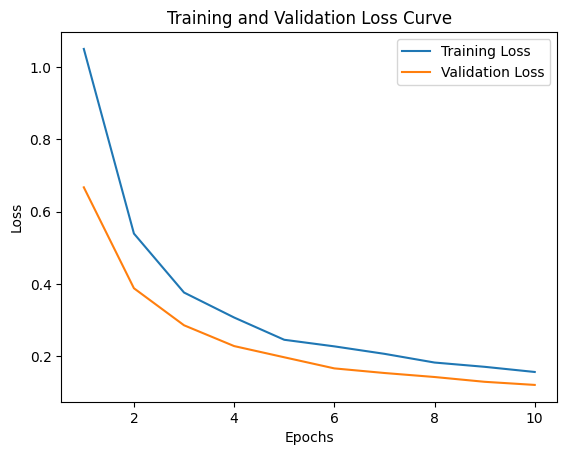

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
#                 logits = outputs.logits
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

# Train the model
num_epochs = 10
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# Plot the training and validation loss curves
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()


# saliency maps corresponding to any 1 image from each class in the following two cases:

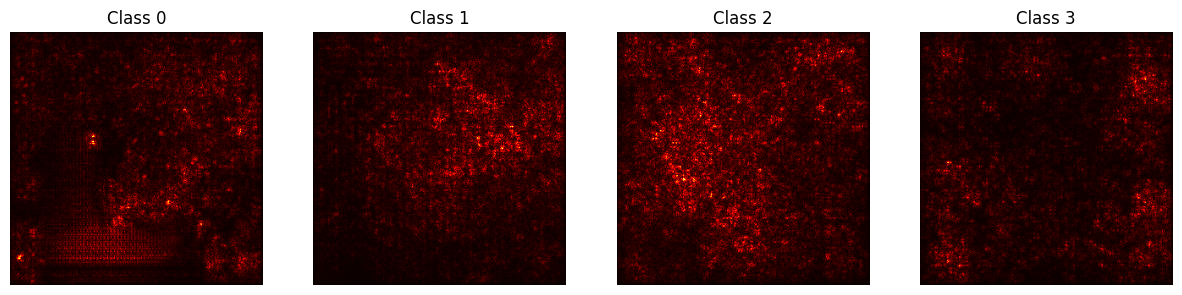

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_saliency_map(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_tensor.requires_grad = True

    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

    model.zero_grad()
    loss = output[0, predicted_class]
    loss.backward()

    saliency_map = image_tensor.grad.data.abs().max(dim=1)[0].squeeze().cpu().numpy()
    return saliency_map
# Choose one image from each class
class_images = {}
for class_idx in range(len(dataset.classes)):
    class_images[class_idx] = dataset.imgs[dataset.targets.index(class_idx)][0]

# Generate saliency maps for each class image
saliency_maps = {}
for class_idx, image_path in class_images.items():
    saliency_map = generate_saliency_map(model, image_path)
    saliency_maps[class_idx] = saliency_map

# Display the saliency maps
fig, axs = plt.subplots(1, len(dataset.classes), figsize=(15, 5))
if len(dataset.classes) == 1:
    axs = [axs]  # If only one class, convert to list for iteration

for class_idx, ax in enumerate(axs):
    ax.imshow(saliency_maps[class_idx], cmap='hot')
    ax.set_title(f"Class {class_idx}")
    ax.axis('off')

plt.show()




# Finetune only the last layer and test it

In [14]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


In [12]:
# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Extract logits from InceptionOutputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


Epoch 1/10, Train Loss: 1.0622
Epoch 2/10, Train Loss: 0.5353
Epoch 3/10, Train Loss: 0.3742
Epoch 4/10, Train Loss: 0.2951
Epoch 5/10, Train Loss: 0.2491
Epoch 6/10, Train Loss: 0.2247
Epoch 7/10, Train Loss: 0.2019
Epoch 8/10, Train Loss: 0.1854
Epoch 9/10, Train Loss: 0.1720
Epoch 10/10, Train Loss: 0.1681
